In [1]:
import numpy as np
import random
import json
import torch, torch.nn as nn
from torchvision import models, transforms
import pandas as pd
import matplotlib.pyplot as plt

ckpt_path = "/Users/avduarte/Desktop/Doutoramento/Cadeiras/CMU/Trustworthy AI/HW1/resnet18_l2_eps0.ckpt"  # your file
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)

# Extract the state_dict from the checkpoint
checkpoint_state_dict = ckpt['model']

# Remove the "module.model." prefix -> The true model was nested inside a DataParallel wrapper
model_state_dict = {}
for key, value in checkpoint_state_dict.items():
    if key.startswith('module.model.'):
        # Remove the "module.model." prefix
        new_key = key[len('module.model.'):]
        model_state_dict[new_key] = value


model = models.resnet18(num_classes=1000)
model.load_state_dict(model_state_dict)

# Move model to device (MPS)
model = model.to(device)

# Set model to evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
from datasets import load_dataset
dataset = load_dataset("mrm8488/ImageNet1K-val")

# Load labels mapping
with open('labels.json', 'r') as f:
    labels_mapping = json.load(f)

# Create index-to-class-name mapping (using natural order from JSON)
class_names = list(labels_mapping.values())
index_to_class_name = {i: class_names[i] for i in range(len(class_names))}

# Add string labels column to dataset
def add_label_str(example):
    example['label_str'] = index_to_class_name[example['label']]
    return example

# I want to add the readable class names to the dataset for easier interpretation
dataset = dataset.map(add_label_str)

# Seeds for reproducibility
torch.manual_seed(2319)
np.random.seed(2319)
random.seed(2319)

# ImageNet preprocessing (standard for ResNet models)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.convert('RGB')),  # Ensure RGB format
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Shuffle the dataset indices
total_samples = len(dataset["train"])
print(f"Total samples in dataset: {total_samples}")
all_indices = list(range(total_samples))
random.shuffle(all_indices)

Repo card metadata block was not found. Setting CardData to empty.


Total samples in dataset: 50000


In [3]:
# I know we want to sample 100 images at random, but in order to ensure the attack is working, we need to fine 100 images that are correctly classified beforehand
final_sample_indices_untargeted = []

for idx in all_indices:
    sample = dataset["train"][idx]
    image = transform(sample["image"]).unsqueeze(0).to(device)
    true_label = sample["label"]
    
    with torch.no_grad():
        pred = model(image).argmax(dim=1).item()
    
    if pred == true_label:
        final_sample_indices_untargeted.append(idx)
    
    # Stop when we have 100 correctly classified images
    if len(final_sample_indices_untargeted) == 100:
        break

In [4]:
# Here I know again that we want to sample 100 images at random, but in order to ensure the attack is working, we need to fine 100 images that are correctly classified beforehand.
# After this we will also sample along a new target class for each image.

final_sample_indices_targeted = []
target_labels = {}  # store mapping: idx -> target class

for idx in all_indices:
    sample = dataset["train"][idx]
    image = transform(sample["image"]).unsqueeze(0).to(device)
    true_label = sample["label"]

    with torch.no_grad():
        pred = model(image).argmax(dim=1).item()

    if pred == true_label:  # ensure clean classification is correct, we pick a random target label from the 999 non-true classes
        possible_targets = list(range(len(class_names)))
        possible_targets.remove(true_label)
        target_label = random.choice(possible_targets)

        final_sample_indices_targeted.append(idx)
        target_labels[idx] = target_label

    if len(final_sample_indices_targeted) == 100:
        break

In [5]:
def pgd_attack(model, image, target, eps, alpha, steps, norm='linf', targeted=False, loss_type='ce'):
    """
    Simple PGD attack with CE and CW losses
    
    Args:
        model: Neural network model
        image: Input image tensor [1, 3, 224, 224]
        target: Target class (targeted) or true class (untargeted)
        eps: Maximum perturbation magnitude
        alpha: Step size
        steps: Number of iterations
        norm: 'linf' or 'l2'
        targeted: True for targeted attack, False for untargeted
        loss_type: 'ce' for Cross-Entropy, 'cw' for Carlini-Wagner
    
    Returns:
        perturbed_image: Adversarial example
        success: Whether attack succeeded
    """
    model.eval()
    
    # Initialize with random noise within epsilon ball
    if norm == 'linf':
        # Random uniform noise in [-eps, eps]
        noise = torch.zeros_like(image).uniform_(-eps, eps)
        adv_image = image + noise
    else:  # norm == 'l2'
        # Random noise with L2 norm <= eps
        noise = torch.randn_like(image)
        noise_norm = torch.norm(noise.view(noise.shape[0], -1), dim=1, keepdim=True)
        noise_norm = noise_norm.view(-1, 1, 1, 1)
        # Sample radius uniformly and direction uniformly on sphere
        radius = eps * torch.rand(1).item()
        noise = noise / (noise_norm + 1e-8) * radius
        adv_image = image + noise
    
    adv_image = adv_image.detach().requires_grad_(True)
    
    # Optional confidence parameter (kappa) for CW hinge; set to 0 by default
    kappa = 0.1

    for step in range(steps):
        adv_image.requires_grad_(True)
        
        # Forward pass
        output = model(adv_image)
        
        # Loss calculation based on loss type
        if loss_type == 'ce':
            # Cross-Entropy loss
            loss = nn.CrossEntropyLoss()(output, target.unsqueeze(0))
            if targeted:
                loss = -loss  # minimize CE for the target class via ascent on -CE
        
        else:  # loss_type == 'cw'
            # CW-style hinge on logit margins within epsilon-ball PGD
            logits = output
            tgt = target.view(-1)
            batch_size, num_classes = logits.shape

            # Gather real/target logits
            real_or_target_logit = logits.gather(1, tgt.unsqueeze(1)).squeeze(1)

            # Max logit among all non-(true/target) classes
            idx = torch.arange(batch_size, device=logits.device)
            mask_logits = logits.clone()
            mask_logits[idx, tgt] = -1e9
            other_logit, _ = mask_logits.max(dim=1)

            if targeted:
                # f_t(x) = max(other - target + kappa, 0); we want to MINIMIZE f_t
                f = torch.clamp(other_logit - real_or_target_logit + kappa, min=0.0)
            else:
                # f_u(x) = max(real - other + kappa, 0); we want to MINIMIZE f_u
                f = torch.clamp(real_or_target_logit - other_logit + kappa, min=0.0)

            # Use ascent on negative f to effectively minimize f
            loss = -f.mean()
            
        # Backward pass
        model.zero_grad()
        loss.backward()
        
        # Get gradients
        grad = adv_image.grad.data
        
        # Update based on norm
        if norm == 'linf':
            # L∞ norm: sign of gradient
            adv_image = adv_image + alpha * grad.sign()
            # Project to L∞ ball
            delta = torch.clamp(adv_image - image, min=-eps, max=eps)
            adv_image = image + delta
        
        else:  # norm == 'l2'
            # L2 norm: normalize gradient
            grad_norm = torch.norm(grad.view(grad.shape[0], -1), dim=1, keepdim=True)
            grad_norm = grad_norm.view(-1, 1, 1, 1)
            grad_normalized = grad / (grad_norm + 1e-8)
            adv_image = adv_image + alpha * grad_normalized
            
            # Project to L2 ball
            delta = adv_image - image
            delta_norm = torch.norm(delta.view(delta.shape[0], -1), dim=1, keepdim=True)
            delta_norm = delta_norm.view(-1, 1, 1, 1)
            scale = torch.minimum(torch.ones_like(delta_norm), eps / (delta_norm + 1e-8))
            adv_image = image + delta * scale
        
        # Detach to avoid gradient accumulation across steps
        adv_image = adv_image.detach()
    
    # Check if attack succeeded
    with torch.no_grad():
        final_pred = model(adv_image).argmax(dim=1).item()
        if targeted:
            success = (final_pred == target.item())
        else:
            success = (final_pred != target.item())
    
    return adv_image, success

In [7]:
# Define epsilon grids as specified in the assignment
eps_linf = [0, 1/255, 2/255, 3/255, 4/255, 5/255, 6/255, 7/255, 8/255]  # L∞ norm
eps_l2 = np.linspace(0, 3.0, 9)  # L2 norm: equally spaced values in [0, 3.0]

print("Epsilon grids:")
print(f"L∞: {eps_linf}")
print(f"L2: {eps_l2}")

# Attack parameters
steps = 40  # PGD iterations
alpha_factor = 4  # alpha = eps/4

print(f"\nAttack settings:")
print(f"PGD steps: {steps}")
print(f"Step size: eps/{alpha_factor}")

Epsilon grids:
L∞: [0, 0.00392156862745098, 0.00784313725490196, 0.011764705882352941, 0.01568627450980392, 0.0196078431372549, 0.023529411764705882, 0.027450980392156862, 0.03137254901960784]
L2: [0.    0.375 0.75  1.125 1.5   1.875 2.25  2.625 3.   ]

Attack settings:
PGD steps: 40
Step size: eps/4


In [8]:
# Initialize results storage
results = {
    'untargeted': {
        ('linf', 'ce'): [],
        ('linf', 'cw'): [],
        ('l2', 'ce'): [],
        ('l2', 'cw'): []
    },
    'targeted': {
        ('linf', 'ce'): [],
        ('linf', 'cw'): [],
        ('l2', 'ce'): [],
        ('l2', 'cw'): []
    }
}

# Track which eps values were used per condition
eps_used = {
    'untargeted': {('linf','ce'): [], ('linf','cw'): [], ('l2','ce'): [], ('l2','cw'): []},
    'targeted':   {('linf','ce'): [], ('linf','cw'): [], ('l2','ce'): [], ('l2','cw'): []},
}

# Conditions to test
norms = ['linf', 'l2']
losses = ['ce','cw']
# losses = ['cw']

print("Running adversarial attacks")
# Base grids and step sizes for extending epsilon further if needed
base_eps = {
    'linf': list(eps_linf),
    'l2': [float(x) for x in eps_l2]
}

step_eps = {
    'linf': (eps_linf[1] - eps_linf[0]) if len(eps_linf) > 1 else (1/255),
    'l2': float(eps_l2[1] - eps_l2[0]) if len(eps_l2) > 1 else 0.25
}

max_eps_cap = {
    'linf': 32/255,   # safety cap
    'l2': 10.0        # safety cap
}

# Helper to compute success rate for a given eps and condition
def compute_success_rate(norm, loss, attack_type, eps):
    alpha = eps / alpha_factor if eps > 0 else 0
    successes = 0
    if attack_type == 'untargeted':
        for idx in final_sample_indices_untargeted:
            sample = dataset["train"][idx]
            image = transform(sample["image"]).unsqueeze(0).to(device)
            true_label = torch.tensor(sample["label"]).to(device)
            if eps == 0:
                success = False
            else:
                _, success = pgd_attack(
                    model, image, true_label, eps, alpha, steps,
                    norm=norm, targeted=False, loss_type=loss
                )
            if success:
                successes += 1
        denom = len(final_sample_indices_untargeted)
    else:  # targeted
        for idx in final_sample_indices_targeted:
            sample = dataset["train"][idx]
            image = transform(sample["image"]).unsqueeze(0).to(device)
            target_label = torch.tensor(target_labels[idx]).to(device)
            if eps == 0:
                success = False
            else:
                _, success = pgd_attack(
                    model, image, target_label, eps, alpha, steps,
                    norm=norm, targeted=True, loss_type=loss
                )
            if success:
                successes += 1
        denom = len(final_sample_indices_targeted)
    return successes / max(denom, 1)

# For each condition, run full base sweep; then extend only if 100% ASR not achieved anywhere
for norm in norms:
    for loss in losses:
        print(f"\n--- Testing {norm.upper()} norm with {loss.upper()} loss ---")
        base_list = base_eps[norm].copy()
        step = step_eps[norm]
        cap = max_eps_cap[norm]

        for attack_type in ['untargeted', 'targeted']:
            print(f"  {attack_type.capitalize()} attacks:")
            key = (norm, loss)
            eps_values = []
            rates = []

            # Full base sweep (0..8/255 for L∞, 0..3.0 for L2), no early stop
            for eps in base_list:
                rate = compute_success_rate(norm, loss, attack_type, eps)
                eps_values.append(float(eps))
                rates.append(rate)
                print(f"    eps={eps:.4f}: {rate:.2%}")

            # Extend epsilon only if we never reached 100% during the base sweep
            extend_steps = 0
            while (max(rates) < 1.0) and (eps_values[-1] < cap) and extend_steps < 50:
                next_eps = float(eps_values[-1] + step)
                rate = compute_success_rate(norm, loss, attack_type, next_eps)
                eps_values.append(next_eps)
                rates.append(rate)
                extend_steps += 1
                print(f"    (extend) eps={next_eps:.4f}: {rate:.2%}")

            # Store
            results[attack_type][key] = rates
            eps_used[attack_type][key] = eps_values

print("\nAll experiments completed!")

Running adversarial attacks

--- Testing LINF norm with CE loss ---
  Untargeted attacks:
    eps=0.0000: 0.00%
    eps=0.0039: 78.00%
    eps=0.0078: 99.00%
    eps=0.0118: 100.00%
    eps=0.0157: 100.00%
    eps=0.0196: 100.00%
    eps=0.0235: 100.00%
    eps=0.0275: 100.00%
    eps=0.0314: 100.00%
  Targeted attacks:
    eps=0.0000: 0.00%
    eps=0.0039: 4.00%
    eps=0.0078: 31.00%
    eps=0.0118: 68.00%
    eps=0.0157: 90.00%
    eps=0.0196: 98.00%
    eps=0.0235: 100.00%
    eps=0.0275: 100.00%
    eps=0.0314: 100.00%

--- Testing LINF norm with CW loss ---
  Untargeted attacks:
    eps=0.0000: 0.00%
    eps=0.0039: 70.00%
    eps=0.0078: 97.00%
    eps=0.0118: 100.00%
    eps=0.0157: 100.00%
    eps=0.0196: 100.00%
    eps=0.0235: 100.00%
    eps=0.0275: 100.00%
    eps=0.0314: 100.00%
  Targeted attacks:
    eps=0.0000: 0.00%
    eps=0.0039: 3.00%
    eps=0.0078: 26.00%
    eps=0.0118: 65.00%
    eps=0.0157: 88.00%
    eps=0.0196: 96.00%
    eps=0.0235: 98.00%
    eps=0.0275: 1

In [9]:
# Create tables with median epsilon values
def find_median_epsilon(success_rates, eps_values):
    """Find the median epsilon where success rate reaches 50% via linear interpolation.
    Assumes eps_values are increasing and success_rates monotonic non-decreasing.
    If 50% never reached, return the last epsilon in the list.
    """
    if not success_rates:
        return float('nan')
    for i, rate in enumerate(success_rates):
        if rate >= 0.5:
            if i == 0:
                return eps_values[0]
            prev_rate = success_rates[i-1]
            curr_rate = rate
            prev_eps = eps_values[i-1]
            curr_eps = eps_values[i]
            if curr_rate > prev_rate:
                median_eps = prev_eps + (0.5 - prev_rate) * (curr_eps - prev_eps) / (curr_rate - prev_rate)
                return median_eps
            else:
                return eps_values[i]
    return eps_values[-1]

# Calculate median epsilons using eps_used per condition
median_results = {}
for attack_type in ['untargeted', 'targeted']:
    median_results[attack_type] = {}
    for (norm, loss) in [('linf', 'ce'), ('linf', 'cw'), ('l2', 'ce'), ('l2', 'cw')]:
        rates = results[attack_type].get((norm, loss), [])
        eps_vals = eps_used[attack_type].get((norm, loss), [])
        if rates and eps_vals:
            median_eps = find_median_epsilon(rates, eps_vals)
        else:
            median_eps = float('nan')
        median_results[attack_type][(norm, loss)] = median_eps

# Create tables
print("=" * 60)
print("RESULTS TABLES")
print("=" * 60)

# Untargeted attacks table
print("\n1. UNTARGETED ATTACKS - Median ε* values:")
print("-" * 50)
untargeted_data = {
    'Loss Function': ['Cross-Entropy (CE)', 'Carlini-Wagner (CW)'],
    'L∞ norm': [
        f"{median_results['untargeted'][('linf', 'ce')]:.4f}" if pd.notna(median_results['untargeted'][('linf', 'ce')]) else 'NA',
        f"{median_results['untargeted'][('linf', 'cw')]:.4f}" if pd.notna(median_results['untargeted'][('linf', 'cw')]) else 'NA'
    ],
    'L2 norm': [
        f"{median_results['untargeted'][('l2', 'ce')]:.4f}" if pd.notna(median_results['untargeted'][('l2', 'ce')]) else 'NA',
        f"{median_results['untargeted'][('l2', 'cw')]:.4f}" if pd.notna(median_results['untargeted'][('l2', 'cw')]) else 'NA'
    ]
}
untargeted_table = pd.DataFrame(untargeted_data)
print(untargeted_table.to_string(index=False))

# Targeted attacks table  
print("\n2. TARGETED ATTACKS - Median ε* values:")
print("-" * 50)
targeted_data = {
    'Loss Function': ['Cross-Entropy (CE)', 'Carlini-Wagner (CW)'],
    'L∞ norm': [
        f"{median_results['targeted'][('linf', 'ce')]:.4f}" if pd.notna(median_results['targeted'][('linf', 'ce')]) else 'NA',
        f"{median_results['targeted'][('linf', 'cw')]:.4f}" if pd.notna(median_results['targeted'][('linf', 'cw')]) else 'NA'
    ],
    'L2 norm': [
        f"{median_results['targeted'][('l2', 'ce')]:.4f}" if pd.notna(median_results['targeted'][('l2', 'ce')]) else 'NA',
        f"{median_results['targeted'][('l2', 'cw')]:.4f}" if pd.notna(median_results['targeted'][('l2', 'cw')]) else 'NA'
    ]
}
targeted_table = pd.DataFrame(targeted_data)
print(targeted_table.to_string(index=False))

RESULTS TABLES

1. UNTARGETED ATTACKS - Median ε* values:
--------------------------------------------------
      Loss Function L∞ norm L2 norm
 Cross-Entropy (CE)  0.0025  0.5625
Carlini-Wagner (CW)  0.0028  0.5893

2. TARGETED ATTACKS - Median ε* values:
--------------------------------------------------
      Loss Function L∞ norm L2 norm
 Cross-Entropy (CE)  0.0099  2.1786
Carlini-Wagner (CW)  0.0103  2.1429


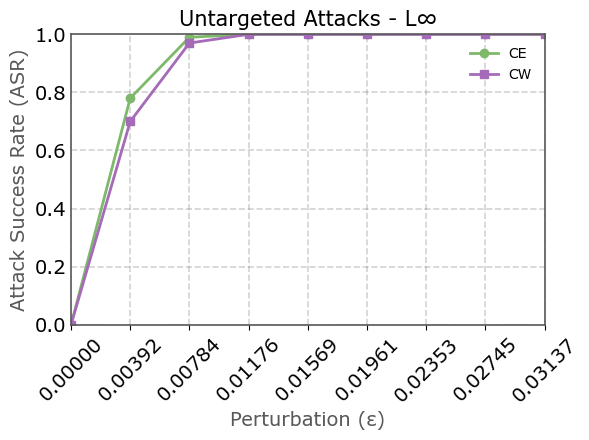

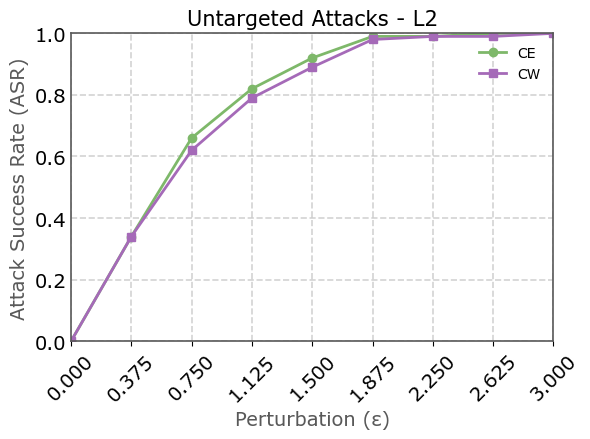

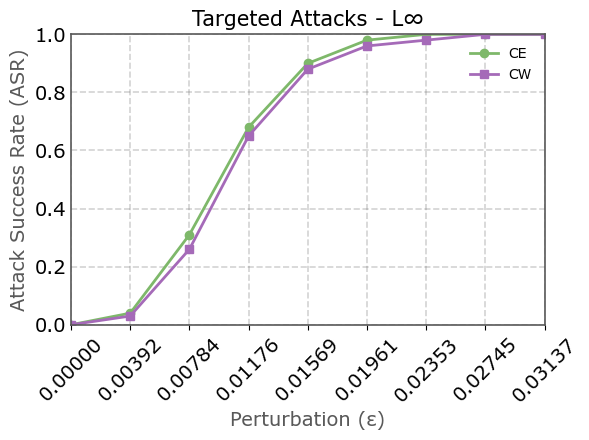

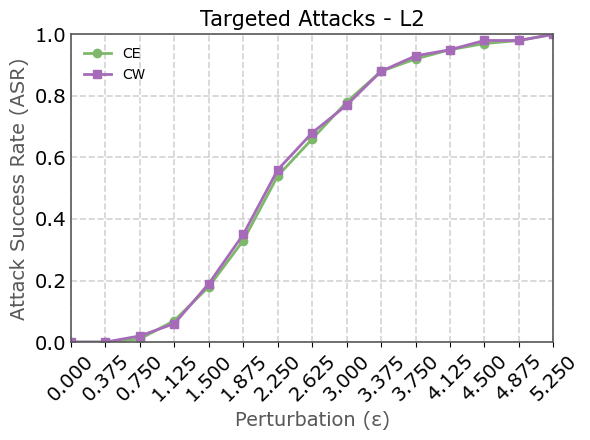

In [38]:
# Control-style fonts
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Verdana'],
    'axes.titlesize': 15,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

# Colors and styles (use existing globals if defined)
_ce_color = globals().get('ce_color', "#7EB86A")
_cw_color = globals().get('cw_color', "#A56AB8")

# Helper to style axes consistently
def _style_axes(ax):
    ax.grid(True, linestyle='--', color='gray', alpha=0.35, linewidth=1.2)
    for side in ['left', 'bottom', 'top', 'right']:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_color('#595959')
        ax.spines[side].set_linewidth(1.2)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14, which='both', length=0)

# Plot helpers
ce_style = dict(color=_ce_color, marker='o', linestyle='-', linewidth=2, markersize=6, label='CE')
cw_style = dict(color=_cw_color, marker='s', linestyle='-', linewidth=2, markersize=6, label='CW')

def _plot_if_data(ax, x, y, style):
    if isinstance(x, (list, tuple)) and isinstance(y, (list, tuple)) and len(x) > 0 and len(y) > 0:
        ax.plot(x, y, **style)

# Utility to set x ticks/limits to all used eps values for a condition
def set_all_eps_ticks_and_limits(ax, *eps_lists):
    vals = []
    for arr in eps_lists:
        if arr:
            vals.extend(arr)
    if len(vals) == 0:
        return
    vals = sorted(set(float(x) for x in vals))
    ax.set_xticks(vals)
    ax.set_xlim(min(vals), max(vals))

# Common figure size for 16:9 aspect
figsize = (6, 4.5)  # width x height in inches

# Figure 1: Untargeted, L∞
fig, ax = plt.subplots(figsize=figsize)
_plot_if_data(ax, eps_used['untargeted'][('linf', 'ce')], results['untargeted'][('linf', 'ce')], ce_style)
_plot_if_data(ax, eps_used['untargeted'][('linf', 'cw')], results['untargeted'][('linf', 'cw')], cw_style)
ax.set_xlabel('Perturbation (ε)', color='#595959')
ax.set_ylabel('Attack Success Rate (ASR)', color='#595959')
ax.set_title('Untargeted Attacks - L∞')
_style_axes(ax)
ax.legend(loc='best', frameon=False)
set_all_eps_ticks_and_limits(ax, eps_used['untargeted'][('linf', 'ce')], eps_used['untargeted'][('linf', 'cw')])
ax.set_ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('asr_untargeted_linf.png', dpi=300)
plt.show()

# Figure 2: Untargeted, L2
fig, ax = plt.subplots(figsize=figsize)
_plot_if_data(ax, eps_used['untargeted'][('l2', 'ce')], results['untargeted'][('l2', 'ce')], ce_style)
_plot_if_data(ax, eps_used['untargeted'][('l2', 'cw')], results['untargeted'][('l2', 'cw')], cw_style)
ax.set_xlabel('Perturbation (ε)', color='#595959')
ax.set_ylabel('Attack Success Rate (ASR)', color='#595959')
ax.set_title('Untargeted Attacks - L2')
_style_axes(ax)
ax.legend(loc='best', frameon=False)
set_all_eps_ticks_and_limits(ax, eps_used['untargeted'][('l2', 'ce')], eps_used['untargeted'][('l2', 'cw')])
ax.set_ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('asr_untargeted_l2.png', dpi=300)
plt.show()

# Figure 3: Targeted, L∞
fig, ax = plt.subplots(figsize=figsize)
_plot_if_data(ax, eps_used['targeted'][('linf', 'ce')], results['targeted'][('linf', 'ce')], ce_style)
_plot_if_data(ax, eps_used['targeted'][('linf', 'cw')], results['targeted'][('linf', 'cw')], cw_style)
ax.set_xlabel('Perturbation (ε)', color='#595959')
ax.set_ylabel('Attack Success Rate (ASR)', color='#595959')
ax.set_title('Targeted Attacks - L∞')
_style_axes(ax)
ax.legend(loc='best', frameon=False)
set_all_eps_ticks_and_limits(ax, eps_used['targeted'][('linf', 'ce')], eps_used['targeted'][('linf', 'cw')])
ax.set_ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('asr_targeted_linf.png', dpi=300)
plt.show()

# Figure 4: Targeted, L2
fig, ax = plt.subplots(figsize=figsize)
_plot_if_data(ax, eps_used['targeted'][('l2', 'ce')], results['targeted'][('l2', 'ce')], ce_style)
_plot_if_data(ax, eps_used['targeted'][('l2', 'cw')], results['targeted'][('l2', 'cw')], cw_style)
ax.set_xlabel('Perturbation (ε)', color='#595959')
ax.set_ylabel('Attack Success Rate (ASR)', color='#595959')
ax.set_title('Targeted Attacks - L2')
_style_axes(ax)
ax.legend(loc='best', frameon=False)
set_all_eps_ticks_and_limits(ax, eps_used['targeted'][('l2', 'ce')], eps_used['targeted'][('l2', 'cw')])
ax.set_ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('asr_targeted_l2.png', dpi=300)
plt.show()

Untargeted PGD sweep (L2, CE) on one image — early stop on first flip
Index: 36003
True label: pill bottle
Original prediction: pill bottle
eps=0.0000 -> success=False, pred=pill bottle
eps=0.0000 -> success=False, pred=pill bottle
eps=0.3750 -> success=False, pred=pill bottle
eps=0.3750 -> success=False, pred=pill bottle
eps=0.7500 -> success=False, pred=pill bottle
eps=0.7500 -> success=False, pred=pill bottle
eps=1.1250 -> success=False, pred=pill bottle
eps=1.1250 -> success=False, pred=pill bottle
eps=1.5000 -> success=False, pred=pill bottle
eps=1.5000 -> success=False, pred=pill bottle
eps=1.8750 -> success=True, pred=rubber eraser, rubber, pencil eraser

Stopped early. Smallest tested ε with flip: 1.8750
eps=1.8750 -> success=True, pred=rubber eraser, rubber, pencil eraser

Stopped early. Smallest tested ε with flip: 1.8750


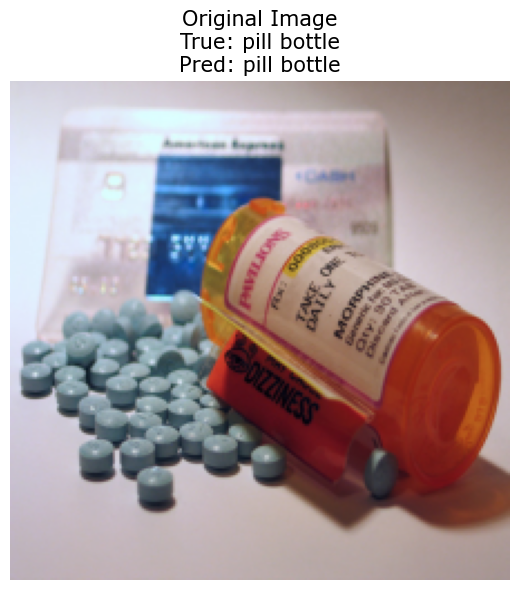

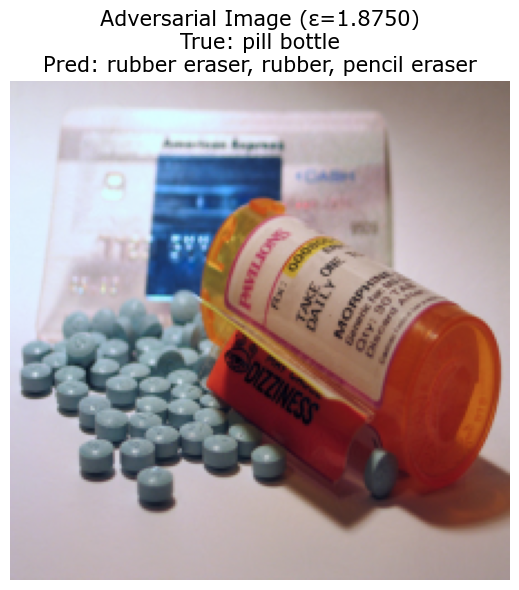

In [39]:
# Denormalize ImageNet tensors for display
def _denorm(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=tensor.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=tensor.device).view(1, 3, 1, 1)
    return tensor * std + mean

eps_grid = np.linspace(0.0, 3.0, 9)
steps = int(globals().get('steps', 40))

# Pick one correctly classified image
if 'final_sample_indices_untargeted' in globals() and len(final_sample_indices_untargeted) > 0:
    idx = final_sample_indices_untargeted[12]
else:
    # Fallback: find the first correctly classified sample
    idx = None
    for i in range(len(dataset['train'])):
        sample_i = dataset['train'][i]
        img_i = transform(sample_i['image']).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_i = model(img_i).argmax(dim=1).item()
        if pred_i == sample_i['label']:
            idx = i
            break
    if idx is None:
        raise RuntimeError("Could not find a correctly classified sample. Run earlier cells to build indices.")

# Load sample
sample = dataset['train'][idx]
image = transform(sample['image']).unsqueeze(0).to(device)
true_label = torch.tensor(sample['label']).to(device)

with torch.no_grad():
    orig_pred = model(image).argmax(dim=1).item()

print("Untargeted PGD sweep (L2, CE) on one image — early stop on first flip")
print(f"Index: {idx}")
print(f"True label: {index_to_class_name[true_label.item()]}")
print(f"Original prediction: {index_to_class_name[orig_pred]}")

first_success_eps = None
first_success_pred = None
best_adv_image = None

for eps in eps_grid:
    alpha = float(eps) / 4.0
    adv_image, success = pgd_attack(
        model, image, true_label,
        eps=float(eps), alpha=alpha, steps=steps,
        norm='l2', targeted=False, loss_type='ce'
    )
    with torch.no_grad():
        adv_pred = model(adv_image).argmax(dim=1).item()
    print(f"eps={float(eps):.4f} -> success={success}, pred={index_to_class_name[adv_pred]}")
    if success:
        first_success_eps = float(eps)
        first_success_pred = adv_pred
        best_adv_image = adv_image.detach()
        break

if first_success_eps is not None:
    print(f"\nStopped early. Smallest tested ε with flip: {first_success_eps:.4f}")

    # Prepare images for display
    orig_vis = _denorm(image).clamp(0, 1).squeeze(0).permute(1, 2, 0).cpu()
    adv_vis = _denorm(best_adv_image).clamp(0, 1).squeeze(0).permute(1, 2, 0).cpu()

    # First plot: Original image
    plt.figure(figsize=(6, 6))
    plt.imshow(orig_vis)
    plt.title(f"Original Image\nTrue: {index_to_class_name[true_label.item()]}\nPred: {index_to_class_name[orig_pred]}")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('original_image.png', dpi=300)
    plt.show()

    # Second plot: Adversarial image
    plt.figure(figsize=(6, 6))
    plt.imshow(adv_vis)
    plt.title(f"Adversarial Image (ε={first_success_eps:.4f})\nTrue: {index_to_class_name[true_label.item()]}\nPred: {index_to_class_name[first_success_pred]}")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('adversarial_image.png', dpi=300)
    plt.show()
else:
    print("\nNo success within ε ∈ [0, 3.0]. Consider larger ε or more steps.")